# NHITS를 활용한 장기 시계열 예측

장기(long-horizon) 예측은 시계열의 *변동성*, *추세 변화(drift)*, 그리고 먼 미래로 갈수록 누적되는 오차 때문에 특히 어렵습니다. `NHITS`는 위계적 보간(hierarchical interpolation)과 다중 입력 주기(multi‑rate input) 처리를 통해 이러한 문제를 완화하여, 계산 비용은 크게 줄이면서도 경쟁력 있는 정확도를 달성합니다.

이 노트북에서는 `NHITS`를 [ETTm2](https://github.com/zhouhaoyi/ETDataset) 데이터셋에 적용하는 방법을 보여줍니다. ETTm2는 2개 관측 지점의 전력 변전소에서 수집된 분 단위 시계열로, 부하(load), 오일 온도 등 다양한 변수를 포함합니다.

아래 순서로 진행합니다: 데이터 로드 → 모델 학습 → 자동 하이퍼파라미터 탐색 → 검증/테스트 평가. 동일한 자원 대비 최신 Transformer 계열 대비 상당히 빠른 학습(대략 수십 배)과 견줄 만한 성능을 얻을 수 있습니다.

### 1. NeuralForecast 설치

In [1]:
%%capture
!pip install neuralforecast datasetsforecast

### 2. ETTh1 데이터 불러오기

`LongHorizon` 도우미 클래스는 ETTm2 데이터를 자동으로 가져오고, 학습/검증/테스트 구간으로 나눈 뒤, 모델이 기대하는 long-format 구조로 정리해 줍니다. 우리가 다루는 데이터셋과 유사한 스키마를 갖도록 전처리를 수행합니다.

In [18]:
import pandas as pd
from datasetsforecast.long_horizon import LongHorizon

# Change this to your own data to try the model
Y_df, _, _ = LongHorizon.load(directory='./', group='ETTh1')
Y_df['ds'] = pd.to_datetime(Y_df['ds'])

# For this excercise we are going to take 20% of the DataSet
n_time = len(Y_df.ds.unique())
val_size = int(.2 * n_time)
test_size = int(.2 * n_time)

Y_df.groupby('unique_id').head(2)

,unique_id,ds,y
0,OT,2016-07-01 00:00:00,1.460552
1,OT,2016-07-01 01:00:00,1.161527


In [19]:
Y_df

,unique_id,ds,y
0,OT,2016-07-01 00:00:00,1.460552
1,OT,2016-07-01 01:00:00,1.161527
2,OT,2016-07-01 02:00:00,1.161527
3,OT,2016-07-01 03:00:00,0.862611
4,OT,2016-07-01 04:00:00,0.525227
...,...,...,...
14395,OT,2018-02-20 19:00:00,-1.866537
14396,OT,2018-02-20 20:00:00,-1.866537
14397,OT,2018-02-20 21:00:00,-1.659595
14398,OT,2018-02-20 22:00:00,-1.628865


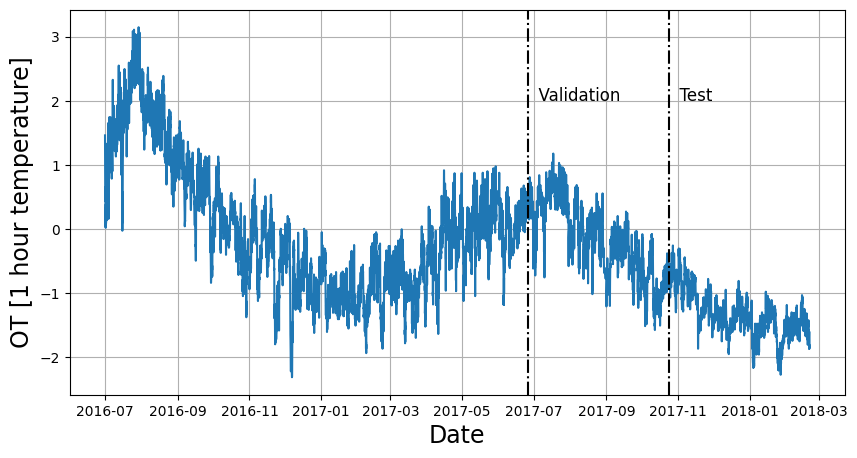

In [23]:
import matplotlib.pyplot as plt

# We are going to plot the temperature of the transformer 
# and marking the validation and train splits
u_id = 'OT'
x_plot = pd.to_datetime(Y_df[Y_df.unique_id==u_id].ds)
y_plot = Y_df[Y_df.unique_id==u_id].y.values

x_val = x_plot[n_time - val_size - test_size]
x_test = x_plot[n_time - test_size]

fig = plt.figure(figsize=(10, 5))
fig.tight_layout()

plt.plot(x_plot, y_plot)
plt.xlabel('Date', fontsize=17)
plt.ylabel('OT [1 hour temperature]', fontsize=17)

plt.axvline(x_val, color='black', linestyle='-.')
plt.axvline(x_test, color='black', linestyle='-.')
plt.text(x_val, 2, '  Validation', fontsize=12)
plt.text(x_test, 2, '  Test', fontsize=12)

plt.grid()

### 3. 하이퍼파라미터 탐색과 예측

`AutoNHITS`는 사전에 정의한 탐색 공간(search space)에서 하이퍼파라미터를 자동으로 탐색합니다. 탐색이 끝나면 최적 구성으로 모델을 재학습하여 예측을 생성합니다. 기본 설정만으로도 SoTA에 근접한 성능을 얻을 수 있으며, 필요에 따라 탐색 공간을 자유롭게 조정해 보세요.

In [24]:
from ray import tune
from neuralforecast.auto import AutoNHITS
from neuralforecast.core import NeuralForecast

In [25]:
horizon = 96 # 4days = 4 * 24 hours.

# Use your own config or AutoNHITS.default_config
nhits_config = {
       "learning_rate": tune.choice([1e-3]),                                     # Initial Learning rate
       "max_steps": tune.choice([1000]),                                         # Number of SGD steps
       "input_size": tune.choice([5 * horizon]),                                 # input_size = multiplier * horizon
       "batch_size": tune.choice([7]),                                           # Number of series in windows
       "windows_batch_size": tune.choice([256]),                                 # Number of windows in batch
       "n_pool_kernel_size": tune.choice([[2, 2, 2], [16, 8, 1]]),               # MaxPool's Kernelsize
       "n_freq_downsample": tune.choice([[168, 24, 1], [24, 12, 1], [1, 1, 1]]), # Interpolation expressivity ratios
       "activation": tune.choice(['ReLU']),                                      # Type of non-linear activation
       "n_blocks":  tune.choice([[1, 1, 1]]),                                    # Blocks per each 3 stacks
       "mlp_units":  tune.choice([[[512, 512], [512, 512], [512, 512]]]),        # 2 512-Layers per block for each stack
       "interpolation_mode": tune.choice(['linear']),                            # Type of multi-step interpolation
       "val_check_steps": tune.choice([100]),                                    # Compute validation every 100 epochs
       "random_seed": tune.randint(1, 10),
    }

`AutoNHITS` 인스턴스를 만들 때는 다음 인자를 정의합니다:

* `h`: 예측 지평(horizon) 길이.
* `input_size`: 입력 윈도 길이.
* `loss`: 학습에 사용할 손실 함수.
* `search_space`: 탐색할 하이퍼파라미터 공간의 정의.
* `num_samples`: 탐색할 설정(configuration) 수.

In [26]:
models = [AutoNHITS(h=horizon,
                    config=nhits_config, 
                    num_samples=5)]

모델 리스트를 `NeuralForecast` 객체에 전달하여 적합(fit)합니다. 롤링 오리진(rolling-origin) 방식의 교차검증을 통해 여러 고정된 절편에서 성능을 추정할 수 있습니다. 또한 `freq`(시계열 주기)는 판다스 오프셋 별칭을 따릅니다(예: '15min', 'H', 'D' 등).

`cross_validation` 메서드를 사용하면 여러 평가 절편에서의 예측을 시뮬레이션할 수 있습니다. 각 절편마다 학습/검증 구간을 증분적으로 이동시키며 선택된 모델을 평가하고, 마지막에는 테스트 구간에 대한 예측을 생성합니다.

In [27]:
%%capture
nf = NeuralForecast(
    models=models,
    freq='H')

Y_hat_df = nf.cross_validation(df=Y_df, val_size=val_size,
                               test_size=test_size, n_windows=None)

2025-10-19 11:24:34,302	INFO tune.py:616 -- [output] This uses the legacy output and progress reporter, as Jupyter notebooks are not supported by the new engine, yet. For more information, please see https://github.com/ray-project/ray/issues/36949
2025-10-19 11:25:25,402	INFO tune.py:1009 -- Wrote the latest version of all result files and experiment state to '/root/ray_results/_train_tune_2025-10-19_11-24-34' in 0.0042s.
INFO:lightning_fabric.utilities.seed:Seed set to 4
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAE           | 0     

### 4. 결과 평가

`AutoNHITS`는 검증 손실과 최적 하이퍼파라미터에 대한 요약을 포함하는 결과 테이블을 제공합니다. 이를 바탕으로 최적 설정을 선택하고, 테스트 세트에 대한 성능을 보고합니다.

In [28]:
nf.models[0].results.get_best_result().config

{'learning_rate': 0.001,
 'max_steps': 1000,
 'input_size': 480,
 'batch_size': 7,
 'windows_batch_size': 256,
 'n_pool_kernel_size': [2, 2, 2],
 'n_freq_downsample': [1, 1, 1],
 'activation': 'ReLU',
 'n_blocks': [1, 1, 1],
 'mlp_units': [[512, 512], [512, 512], [512, 512]],
 'interpolation_mode': 'linear',
 'val_check_steps': 100,
 'random_seed': 4,
 'h': 96,
 'loss': MAE(),
 'valid_loss': MAE()}

In [29]:
y_true = Y_hat_df.y.values
y_hat = Y_hat_df['AutoNHITS'].values

n_series = len(Y_df.unique_id.unique())

y_true = y_true.reshape(n_series, -1, horizon)
y_hat = y_hat.reshape(n_series, -1, horizon)

print('Parsed results')
print('2. y_true.shape (n_series, n_windows, n_time_out):\t', y_true.shape)
print('2. y_hat.shape  (n_series, n_windows, n_time_out):\t', y_hat.shape)

Parsed results
2. y_true.shape (n_series, n_windows, n_time_out):	 (1, 2785, 96)
2. y_hat.shape  (n_series, n_windows, n_time_out):	 (1, 2785, 96)


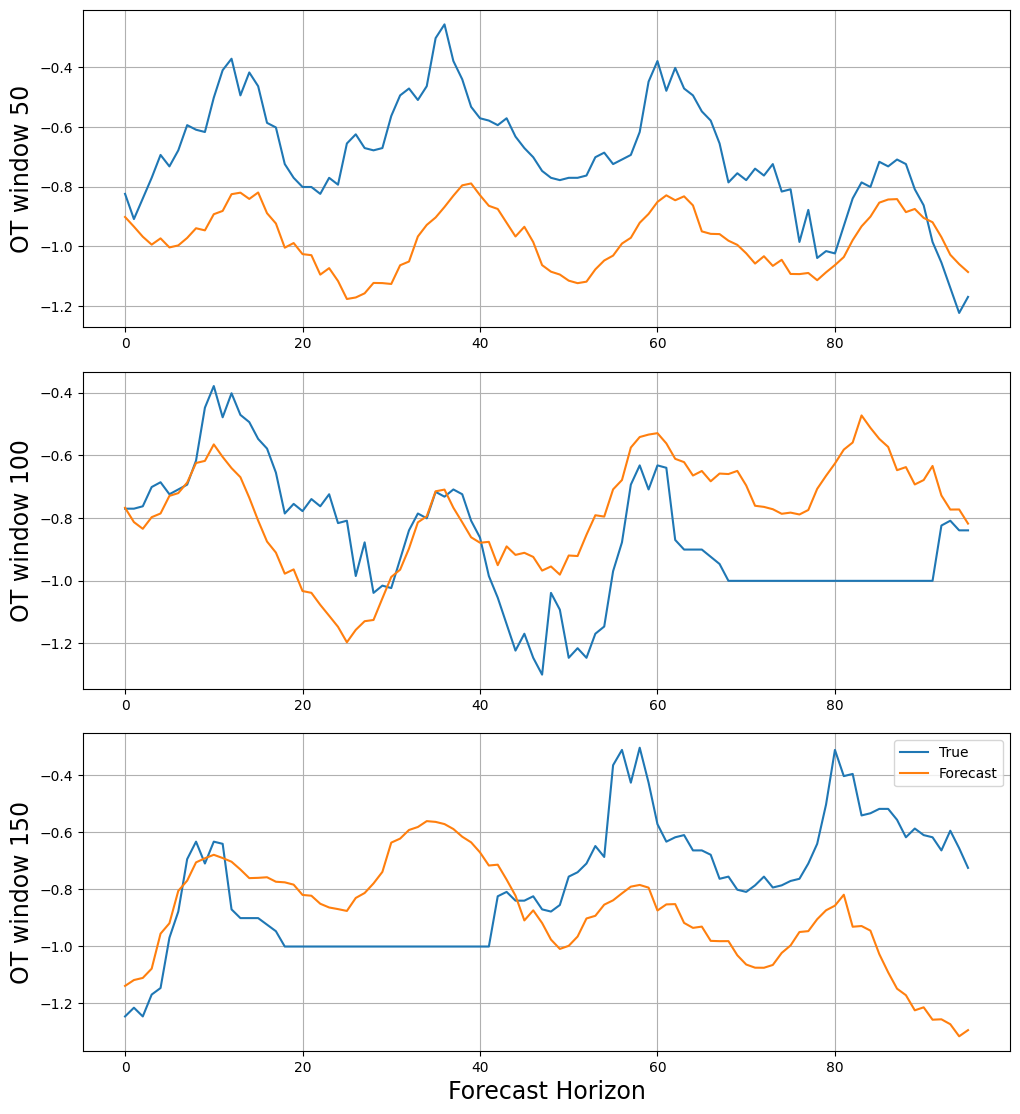

In [34]:
fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(10, 11))
fig.tight_layout()

series = ['OT']
series_idx = 0

for idx, w_idx in enumerate([50, 100, 150]):
  axs[idx].plot(y_true[series_idx, w_idx,:],label='True')
  axs[idx].plot(y_hat[series_idx, w_idx,:],label='Forecast')
  axs[idx].grid()
  axs[idx].set_ylabel(series[series_idx]+f' window {w_idx}', 
                      fontsize=17)
  if idx==2:
    axs[idx].set_xlabel('Forecast Horizon', fontsize=17)
plt.legend()
plt.show()
plt.close()

마지막으로 두 가지 대표 지표(예: MSE 등)에 대한 테스트 오차를 계산합니다. 수식 표기 예시는 아래와 같습니다(기호는 원 논문/라이브러리 표기에 따름):

$$ \text{MSE}_{\text{horizon}} = \frac{1}{|\text{horizon}|} \sum_{\tau} (y_{\tau} - \hat{y}_{\tau})^{2} \qquad $$

In [35]:
from neuralforecast.losses.numpy import mae, mse

print('MAE: ', mae(y_hat, y_true))
print('MSE: ', mse(y_hat, y_true))

MAE:  0.232746427639942
MSE:  0.0919275801667067


### 참고문헌

[Cristian Challu, Kin G. Olivares, Boris N. Oreshkin, Federico Garza, Max Mergenthaler, Abdullah Karim, & Yuriy Nevmyvaka. NHITS: Neural Hierarchical Interpolation for Long‑term Time‑Series Forecasting. AAAI 2023 채택.](https://arxiv.org/abs/2201.12886)